In [11]:
import math
import random
import time

import sklearn.metrics
from numpy import arange, c_
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
# from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import datasets
from sklearn.metrics import roc_auc_score, f1_score, balanced_accuracy_score

import scipy
from scipy import optimize

import numpy as np

from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, RocCurveDisplay, roc_curve

import matplotlib.pyplot as plt

import pandas as pd

import seaborn as sns

sns.reset_orig()


noise = 16
samples = 2425
seed = 244825
classes = 2
train_split = 0.8
test_split = 0.2
repeats = 100

In [12]:
class MyDecisionTreeClassifier():
    class Node():
        def __init__(self, feature_index=None, threshold=None, left=None, right=None, info_gain=None, value=None):
            self.feature_index = feature_index
            self.threshold = threshold
            self.left = left
            self.right = right
            self.info_gain = info_gain

            self.value = value

    def __init__(self, min_samples_split=2, max_depth=2):
        self.root = None

        self.min_samples_split = min_samples_split
        self.max_depth = max_depth

    def build_tree(self, dataset, curr_depth=0):

        X, Y = dataset[:, :-1], dataset[:, -1]
        num_samples, num_features = np.shape(X)

        if num_samples >= self.min_samples_split and curr_depth < self.max_depth:
            best_split = self.get_best_split(dataset, num_samples, num_features)
            if best_split["info_gain"] > 0:
                left_subtree = self.build_tree(best_split["dataset_left"], curr_depth + 1)
                right_subtree = self.build_tree(best_split["dataset_right"], curr_depth + 1)
                return self.Node(best_split["feature_index"], best_split["threshold"],
                                 left_subtree, right_subtree, best_split["info_gain"])

        leaf_value = self.calculate_leaf_value(Y)
        return self.Node(value=leaf_value)

    def get_best_split(self, dataset, num_samples, num_features):

        best_split = {}
        max_info_gain = -float("inf")

        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            for threshold in possible_thresholds:
                # dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                dataset_left = dataset[dataset[:, feature_index] <= threshold]
                dataset_right = dataset[dataset[:, feature_index] > threshold]
                if len(dataset_left) > 0 and len(dataset_right) > 0:
                    # y, left_y, right_y =
                    curr_info_gain = self.information_gain(dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1],
                                                           "entropy")
                    if curr_info_gain > max_info_gain:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["info_gain"] = curr_info_gain
                        max_info_gain = curr_info_gain

        return best_split

    def split(self, dataset, feature_index, threshold):
        # def split(self, X, Y, feature_index, threshold):
        X_left = []
        X_right = []
        for i, row in enumerate(dataset):
            if row[feature_index] <= threshold:
                X_left.append(row)
            else:
                X_right.append(row)

        return np.array(X_left), np.array(X_right)

    def information_gain(self, parent, l_child, r_child, mode="entropy"):

        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        if mode == "gini":
            gain = self.gini_index(parent) - (weight_l * self.gini_index(l_child) + weight_r * self.gini_index(r_child))
        else:
            gain = self.entropy(parent) - (weight_l * self.entropy(l_child) + weight_r * self.entropy(r_child))
        return gain

    def entropy(self, y):

        class_labels = np.unique(y)
        entropy = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            entropy += -p_cls * np.log2(p_cls)
        return entropy

    def gini_index(self, y):

        class_labels = np.unique(y)
        gini = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            gini += p_cls ** 2
        return 1 - gini

    def calculate_leaf_value(self, Y):

        Y = list(Y)
        return max(Y, key=Y.count)

    def print_tree(self, tree=None, indent=" "):

        if not tree:
            tree = self.root

        if tree.value is not None:
            print(tree.value)

        else:
            print("X_" + str(tree.feature_index), "<=", tree.threshold, "?", tree.info_gain)
            print("%sleft:" % (indent), end="")
            self.print_tree(tree.left, indent + indent)
            print("%sright:" % (indent), end="")
            self.print_tree(tree.right, indent + indent)

    def fit(self, X, Y):

        # dataset = np.concatenate((X, Y), axis=1)
        dataset = np.column_stack((X, Y))
        self.root = self.build_tree(dataset)

    def predict(self, X):

        pred = np.empty(shape=len(X))

        for i in range(len(X)):
            pred[i] = self.make_prediction(X[i], self.root)

        return pred

        # preditions = [self.make_prediction(x, self.root) for x in X]
        # return preditions

    def make_prediction(self, x, tree):

        if tree.value is not None:
            return tree.value

        feature_val = x[tree.feature_index]
        if feature_val <= tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)

In [13]:
def tree_function(mdl, X_tr, y_tr, X_te, y_te, silent=False):

    mdl.fit(X_train, y_train)

    y_pred = mdl.predict(X_test)

    if not silent:
        mesh_data = c_[xx.ravel(), yy.ravel()]
        Z = Z = np.asarray(mdl.predict(mesh_data)).reshape(xx.shape)

        plt.figure(figsize=(10, 10))
        plt.contourf(xx, yy, Z, alpha=0.6, cmap = 'ocean')
        plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test)

        cm_model = confusion_matrix(y_test, y_pred)
        tn_model = cm_model[0][0]
        fn_model = cm_model[0][1]
        tp_model = cm_model[1][1]
        fp_model = cm_model[1][0]
        ConfusionMatrixDisplay(cm_model).plot(cmap='cubehelix')

        fpr, tpr, roc_auc = roc_curve(y_test, mdl.predict(X_test))

        rok_model = RocCurveDisplay(fpr=fpr, tpr=tpr)
        rok_model.plot()


        print("Czulosc:", tp_model/(tp_model + fn_model))
        print("Swoistosc:", tn_model/(tn_model + fp_model))
        print("Accuracy:", (tp_model + tn_model) / (tp_model + tn_model + fp_model + fn_model))

        print("ROC auc:", roc_auc_score(y_test, y_pred))
        print("F1 score:", f1_score(y_test, y_pred))
        print("BA score:", balanced_accuracy_score(y_test, y_pred))



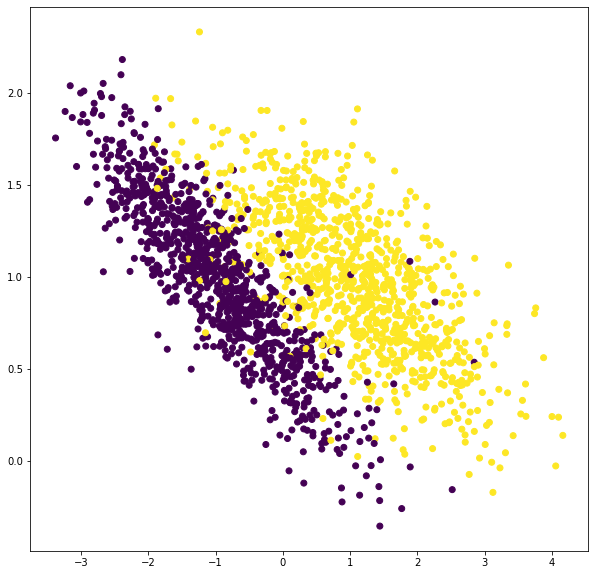

In [14]:
X, y = datasets.make_classification(n_features=2, random_state=seed, n_redundant=0, n_samples=samples, n_classes=2, n_clusters_per_class=1)

# y[y == 0] = -1

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_split, test_size=test_split, random_state=seed)

xx, yy = np.meshgrid(np.arange(X.min(), X.max(), 0.01),
                       np.arange(X.min(), X.max(), 0.01))

plt.figure(figsize=(10,10))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)

Czas wykonania sklearn: 0.008842100000038045
Czulosc: 0.8613445378151261
Swoistosc: 0.8178137651821862
Accuracy: 0.8391752577319588
ROC auc: 0.8397872340425531
F1 score: 0.8401639344262296
BA score: 0.8397872340425532


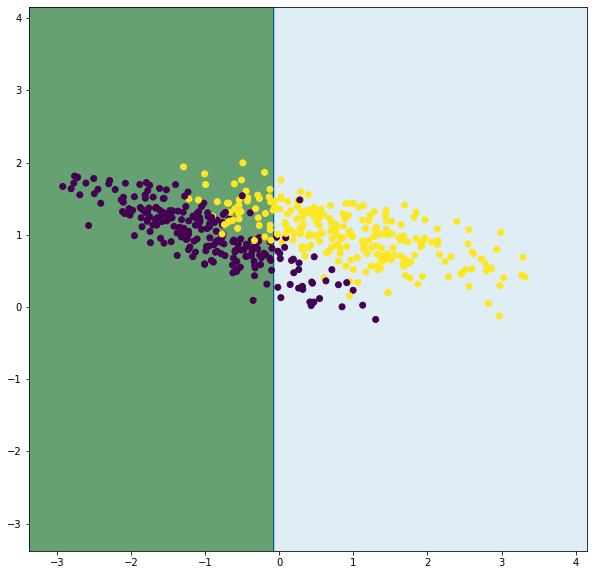

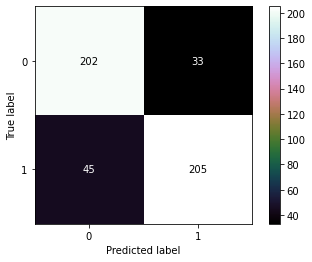

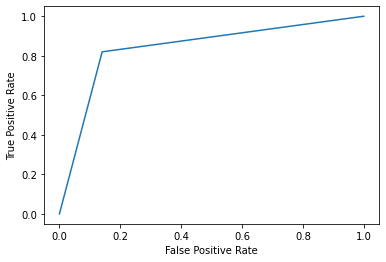

In [15]:
model = DecisionTreeClassifier(max_depth=1, min_samples_split=2)

czasek = time.perf_counter()
for i in range(10):
    tree_function(model, X_train, y_train, X_test, y_test, True)
print('Czas wykonania sklearn:', (time.perf_counter() - czasek))

tree_function(model, X_train, y_train, X_test, y_test)

Czas wykonania wlasna implementacja: 8.578407799999695
Czulosc: 0.8613445378151261
Swoistosc: 0.8178137651821862
Accuracy: 0.8391752577319588
ROC auc: 0.8397872340425531
F1 score: 0.8401639344262296
BA score: 0.8397872340425532


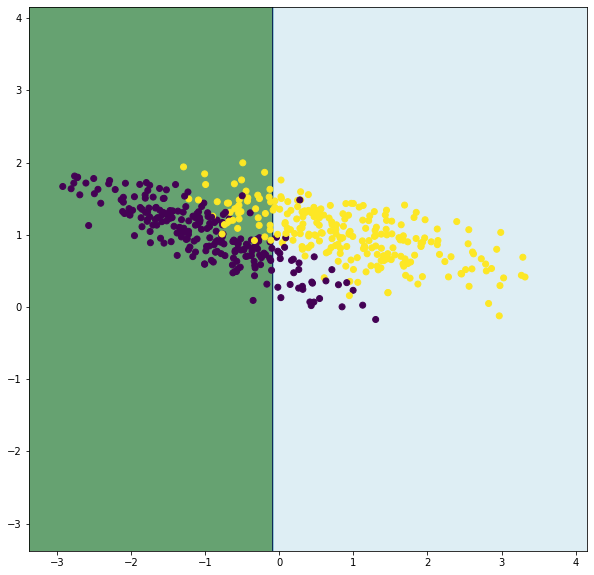

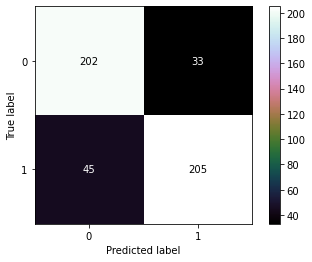

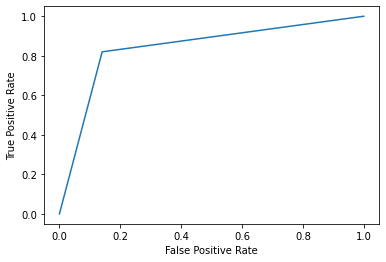

In [16]:
model = MyDecisionTreeClassifier(max_depth=1, min_samples_split=2)

czasek = time.perf_counter()
for i in range(10):
    tree_function(model, X_train, y_train, X_test, y_test, True)
print('Czas wykonania wlasna implementacja:', (time.perf_counter() - czasek))

tree_function(model, X_train, y_train, X_test, y_test)

Czas wykonania sklearn: 0.011392700000214973
Czulosc: 0.8613445378151261
Swoistosc: 0.8178137651821862
Accuracy: 0.8391752577319588
ROC auc: 0.8397872340425531
F1 score: 0.8401639344262296
BA score: 0.8397872340425532


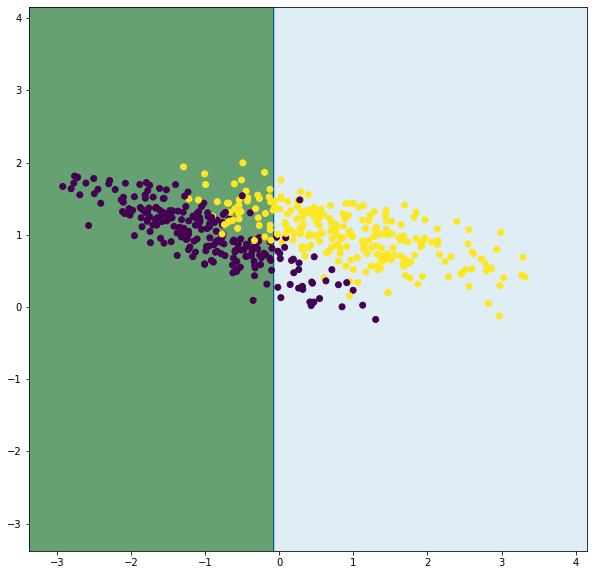

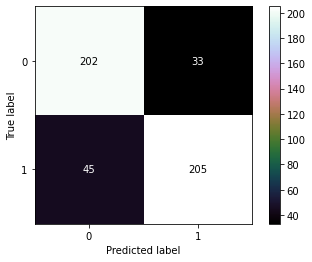

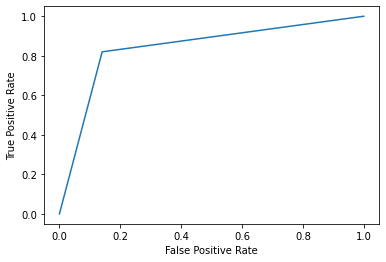

In [17]:
model = DecisionTreeClassifier(max_depth=2, min_samples_split=2)

czasek = time.perf_counter()
for i in range(10):
    tree_function(model, X_train, y_train, X_test, y_test, True)
print('Czas wykonania sklearn:', (time.perf_counter() - czasek))

tree_function(model, X_train, y_train, X_test, y_test)

Czas wykonania wlasna implementacja: 12.614806499999759
Czulosc: 0.8613445378151261
Swoistosc: 0.8178137651821862
Accuracy: 0.8391752577319588
ROC auc: 0.8397872340425531
F1 score: 0.8401639344262296
BA score: 0.8397872340425532


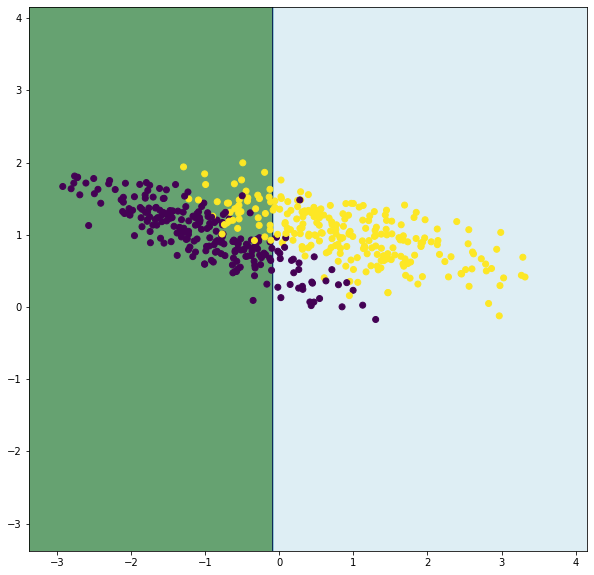

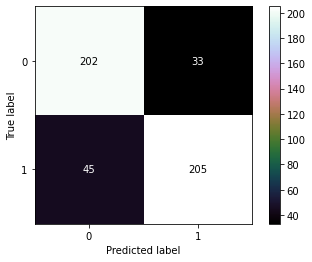

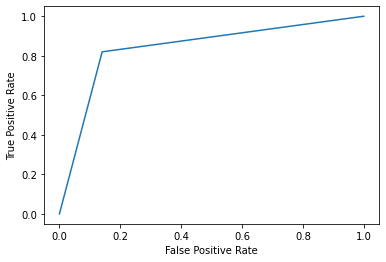

In [18]:
model = MyDecisionTreeClassifier(max_depth=2, min_samples_split=2)

czasek = time.perf_counter()
for i in range(10):
    tree_function(model, X_train, y_train, X_test, y_test, True)
print('Czas wykonania wlasna implementacja:', (time.perf_counter() - czasek))

tree_function(model, X_train, y_train, X_test, y_test)

Czas wykonania sklearn: 0.023993300000256568
Czulosc: 0.9146341463414634
Swoistosc: 0.895397489539749
Accuracy: 0.9051546391752577
ROC auc: 0.9053191489361702
F1 score: 0.9072580645161291
BA score: 0.9053191489361703


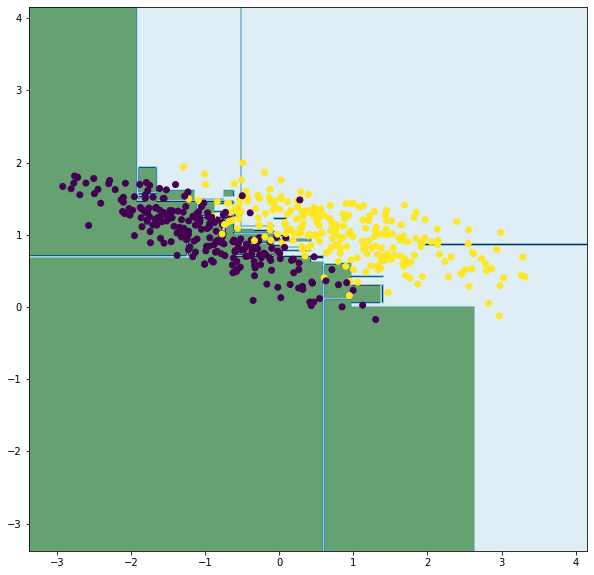

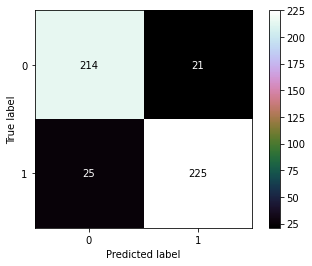

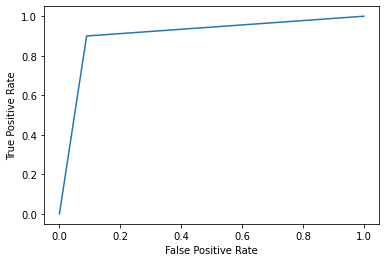

In [19]:
model = DecisionTreeClassifier(max_depth=samples, min_samples_split=2)

czasek = time.perf_counter()
for i in range(10):
    tree_function(model, X_train, y_train, X_test, y_test, True)
print('Czas wykonania sklearn:', (time.perf_counter() - czasek))

tree_function(model, X_train, y_train, X_test, y_test)

Czas wykonania sklearn: 25.838792499999727
Czulosc: 0.9387755102040817
Swoistosc: 0.9166666666666666
Accuracy: 0.9278350515463918
ROC auc: 0.9280851063829787
F1 score: 0.9292929292929293
BA score: 0.9280851063829787


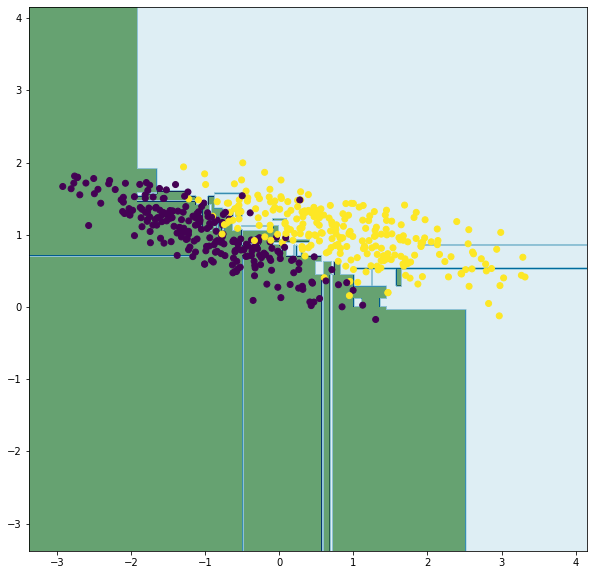

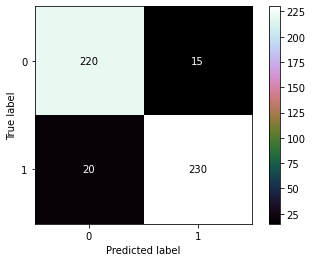

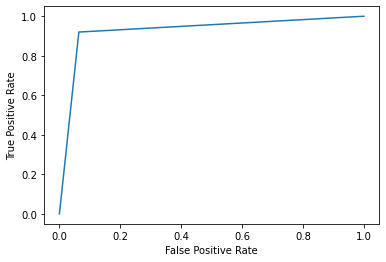

In [20]:
model = MyDecisionTreeClassifier(max_depth=samples, min_samples_split=2)

czasek = time.perf_counter()
for i in range(10):
    tree_function(model, X_train, y_train, X_test, y_test, True)
print('Czas wykonania sklearn:', (time.perf_counter() - czasek))

tree_function(model, X_train, y_train, X_test, y_test)

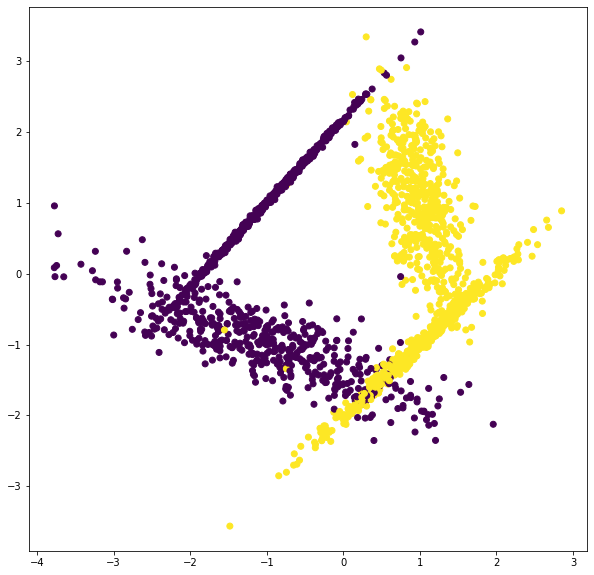

In [21]:
X, y = datasets.make_classification(n_features=2, random_state=seed, n_redundant=0, n_samples=samples, n_classes=2, n_clusters_per_class=2)

# y[y == 0] = -1

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_split, test_size=test_split, random_state=seed)

xx, yy = np.meshgrid(np.arange(X.min(), X.max(), 0.01),
                       np.arange(X.min(), X.max(), 0.01))

plt.figure(figsize=(10,10))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)

Czas wykonania sklearn: 0.011160900000504625
Czulosc: 0.9752066115702479
Swoistosc: 0.9753086419753086
Accuracy: 0.9752577319587629
ROC auc: 0.9752576267727782
F1 score: 0.9752066115702479
BA score: 0.9752576267727783


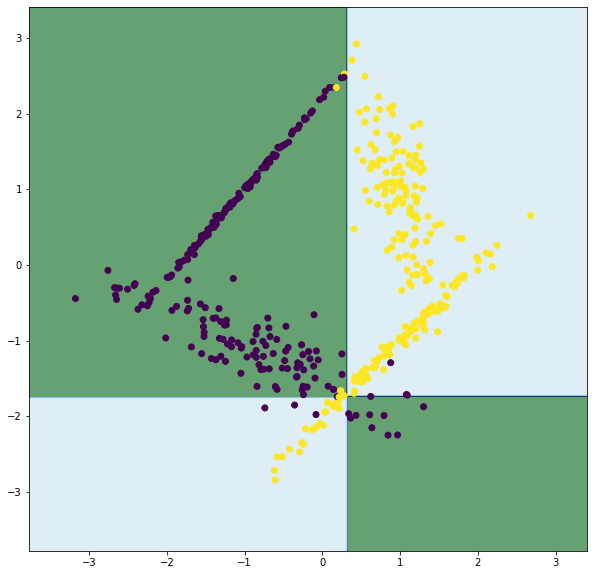

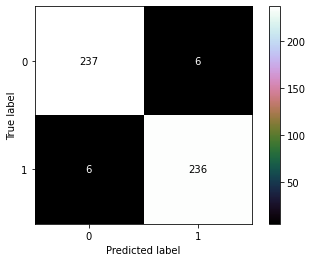

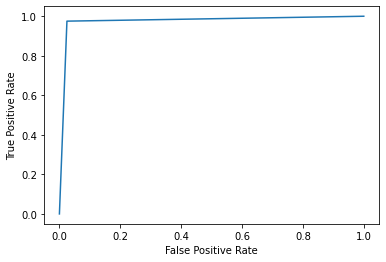

In [22]:
model = DecisionTreeClassifier(max_depth=2, min_samples_split=2)

czasek = time.perf_counter()
for i in range(10):
    tree_function(model, X_train, y_train, X_test, y_test, True)
print('Czas wykonania sklearn:', (time.perf_counter() - czasek))

tree_function(model, X_train, y_train, X_test, y_test)

Czas wykonania sklearn: 12.382146600000851
Czulosc: 0.9791666666666666
Swoistosc: 0.9714285714285714
Accuracy: 0.9752577319587629
ROC auc: 0.9752491242390232
F1 score: 0.9751037344398341
BA score: 0.9752491242390232


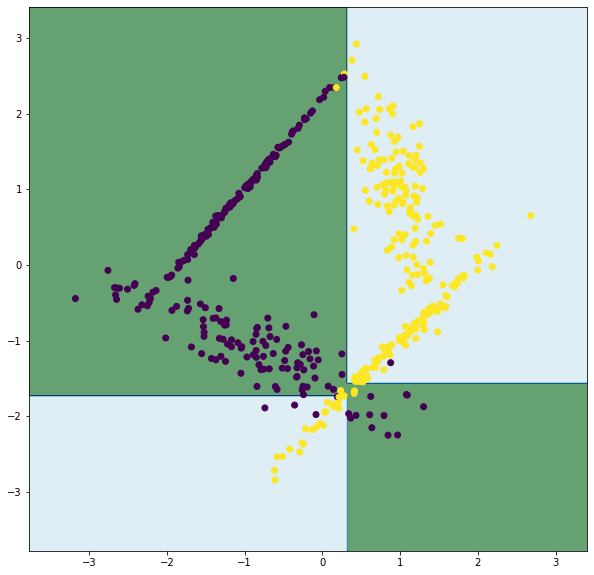

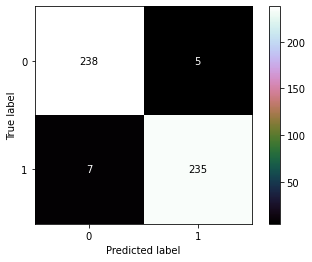

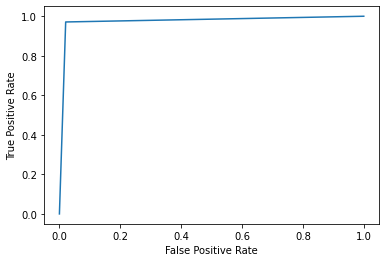

In [23]:
model = MyDecisionTreeClassifier(max_depth=2, min_samples_split=2)

czasek = time.perf_counter()
for i in range(10):
    tree_function(model, X_train, y_train, X_test, y_test, True)
print('Czas wykonania sklearn:', (time.perf_counter() - czasek))

tree_function(model, X_train, y_train, X_test, y_test)

Czas wykonania sklearn: 0.030402599999433733
Czulosc: 0.9831223628691983
Swoistosc: 0.9637096774193549
Accuracy: 0.9731958762886598
ROC auc: 0.9731745060027888
F1 score: 0.9728601252609603
BA score: 0.9731745060027888


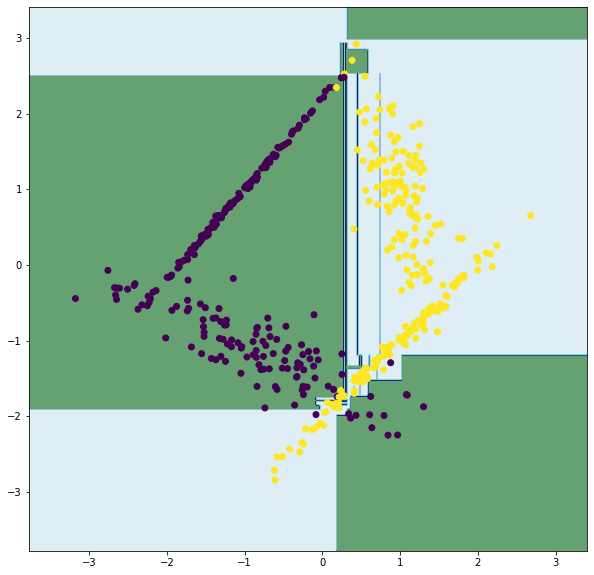

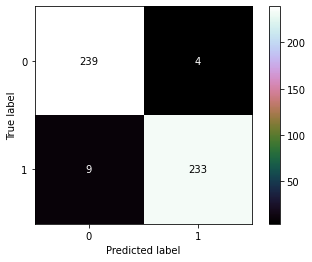

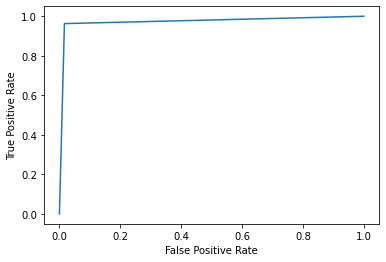

In [24]:
model = DecisionTreeClassifier(max_depth=samples, min_samples_split=2)

czasek = time.perf_counter()
for i in range(10):
    tree_function(model, X_train, y_train, X_test, y_test, True)
print('Czas wykonania sklearn:', (time.perf_counter() - czasek))

tree_function(model, X_train, y_train, X_test, y_test)

Czas wykonania sklearn: 28.733479700000316
Czulosc: 0.9588477366255144
Swoistosc: 0.9628099173553719
Accuracy: 0.9608247422680413
ROC auc: 0.9608288269904431
F1 score: 0.9608247422680413
BA score: 0.9608288269904431


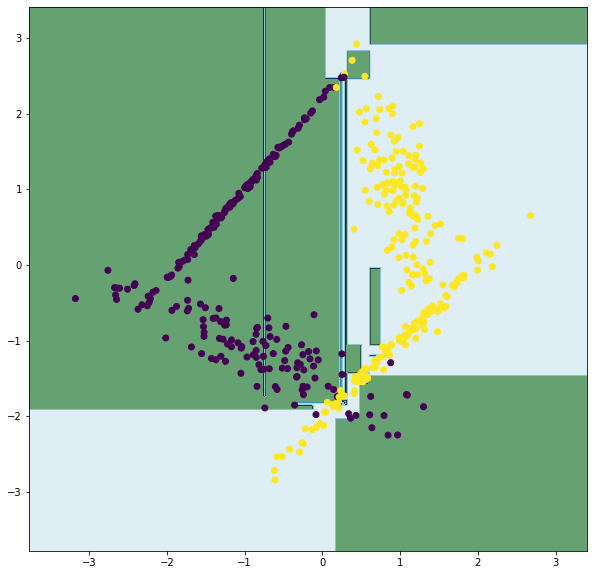

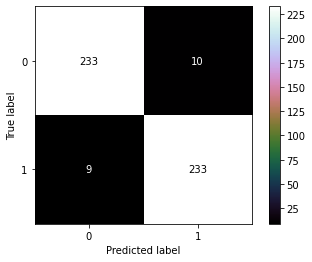

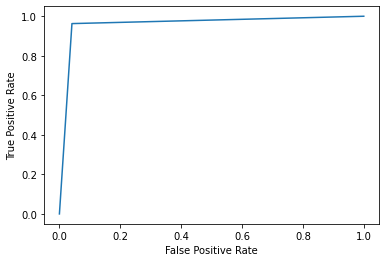

In [25]:
model = MyDecisionTreeClassifier(max_depth=samples, min_samples_split=2)

czasek = time.perf_counter()
for i in range(10):
    tree_function(model, X_train, y_train, X_test, y_test, True)
print('Czas wykonania sklearn:', (time.perf_counter() - czasek))

tree_function(model, X_train, y_train, X_test, y_test)

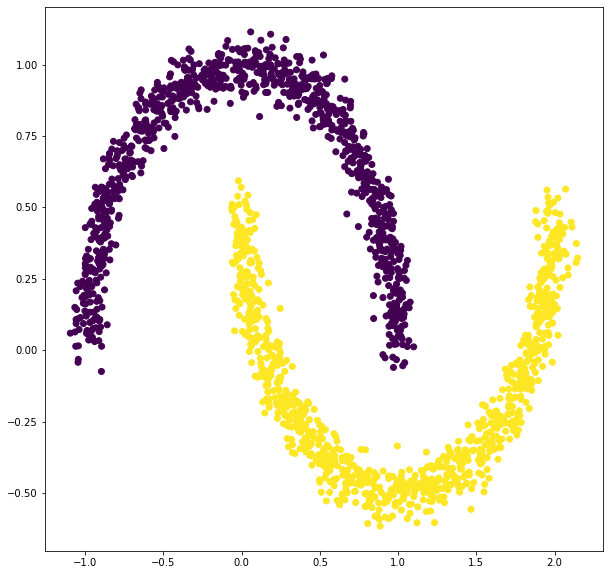

In [26]:
# X, y = datasets.make_classification(n_features=2, random_state=seed, n_redundant=0, n_samples=samples, n_classes=2, n_clusters_per_class=1)
X, y = datasets.make_moons(random_state=seed, n_samples=samples, noise=0.05)

# y[y == 0] = -1

poly = PolynomialFeatures(degree=4, include_bias=False)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_split, test_size=test_split, random_state=seed, shuffle=True, stratify=y)

xx, yy = np.meshgrid(np.arange(X.min(), X.max(), 0.01),
                       np.arange(X.min(), X.max(), 0.01))

# X_train = my_normalize(X_train)
# X_test = my_normalize(X_test)
# X_train = poly.fit_transform(X_train)
# X_test = poly.fit_transform(X_test)


plt.figure(figsize=(10,10))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)

Czas wykonania sklearn: 0.007900300000073912
Czulosc: 0.9333333333333333
Swoistosc: 0.7896551724137931
Accuracy: 0.8474226804123711
ROC auc: 0.8476260925755874
F1 score: 0.8310502283105022
BA score: 0.8476260925755875


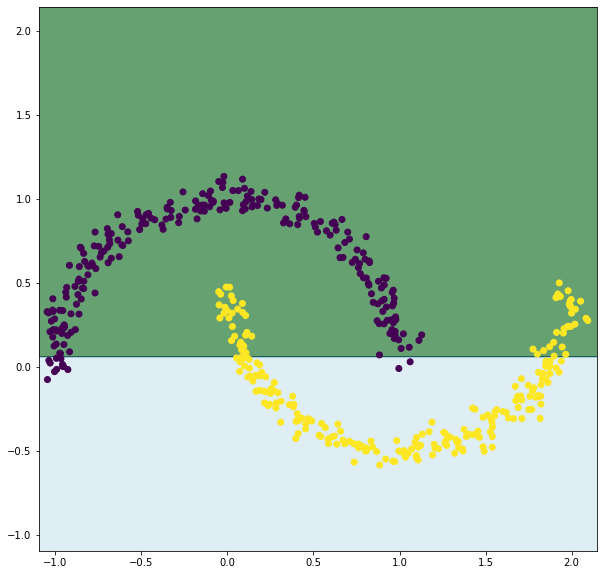

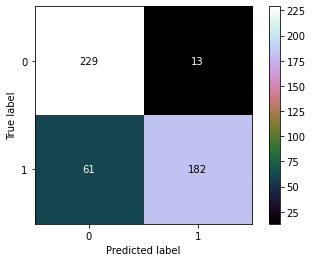

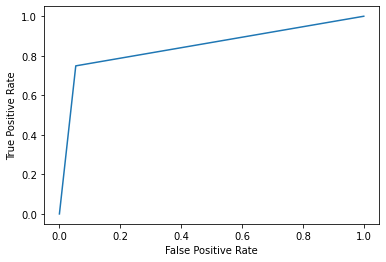

In [27]:
model = DecisionTreeClassifier(max_depth=1, min_samples_split=2)

czasek = time.perf_counter()
for i in range(10):
    tree_function(model, X_train, y_train, X_test, y_test, True)
print('Czas wykonania sklearn:', (time.perf_counter() - czasek))

tree_function(model, X_train, y_train, X_test, y_test)

Czas wykonania sklearn: 8.352262599999449
Czulosc: 0.7232142857142857
Swoistosc: 1.0
Accuracy: 0.8082474226804124
ROC auc: 0.8078512396694215
F1 score: 0.839378238341969
BA score: 0.8078512396694215


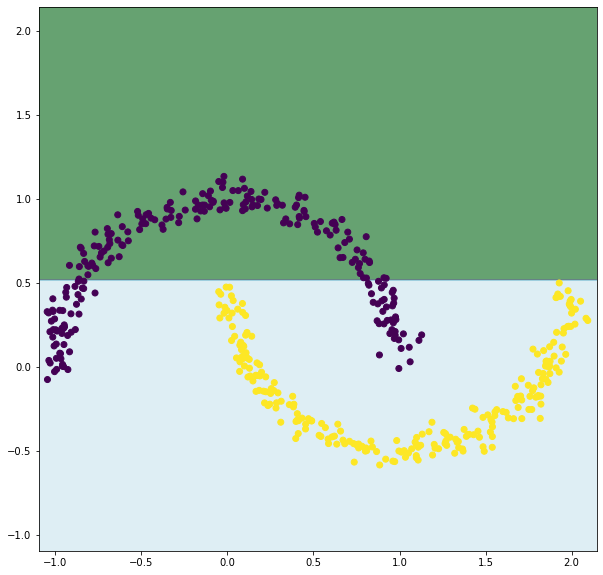

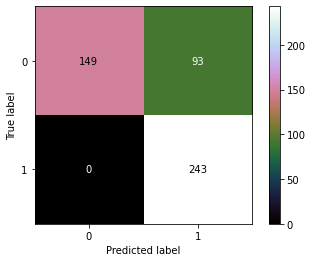

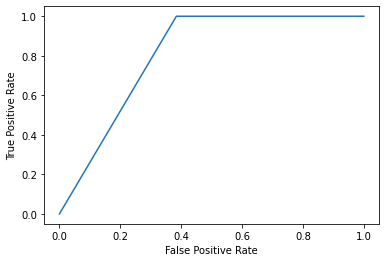

In [28]:
model = MyDecisionTreeClassifier(max_depth=1, min_samples_split=2)

czasek = time.perf_counter()
for i in range(10):
    tree_function(model, X_train, y_train, X_test, y_test, True)
print('Czas wykonania sklearn:', (time.perf_counter() - czasek))

tree_function(model, X_train, y_train, X_test, y_test)

Czas wykonania sklearn: 0.010691500000575616
Czulosc: 0.9906976744186047
Swoistosc: 0.8888888888888888
Accuracy: 0.934020618556701
ROC auc: 0.9341393735333129
F1 score: 0.9301310043668122
BA score: 0.934139373533313


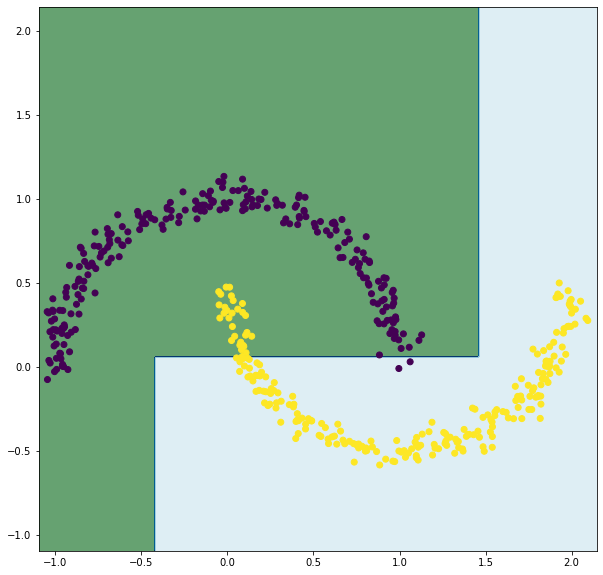

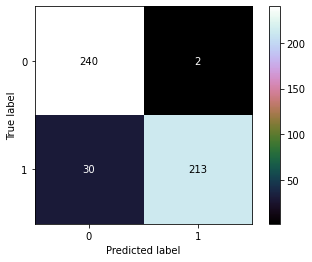

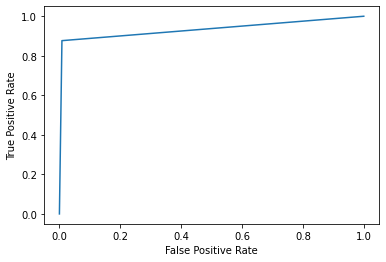

In [29]:
model = DecisionTreeClassifier(max_depth=2, min_samples_split=2)

czasek = time.perf_counter()
for i in range(10):
    tree_function(model, X_train, y_train, X_test, y_test, True)
print('Czas wykonania sklearn:', (time.perf_counter() - czasek))

tree_function(model, X_train, y_train, X_test, y_test)

Czas wykonania sklearn: 12.973325699999805
Czulosc: 0.8586572438162544
Swoistosc: 1.0
Accuracy: 0.9175257731958762
ROC auc: 0.9173553719008265
F1 score: 0.9239543726235742
BA score: 0.9173553719008265


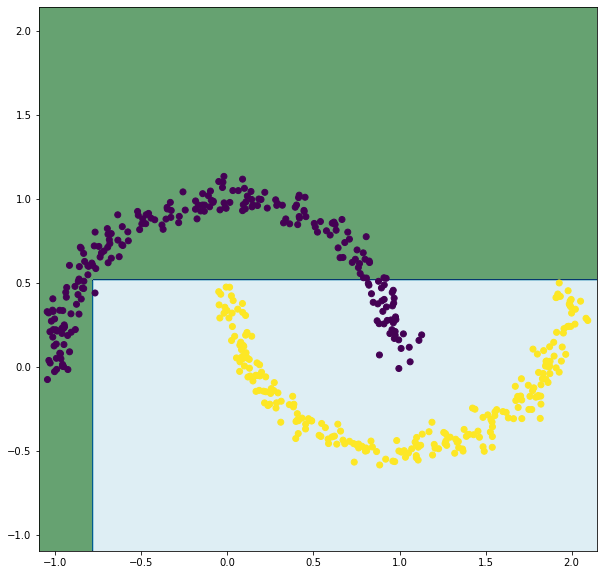

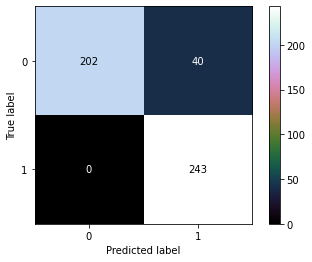

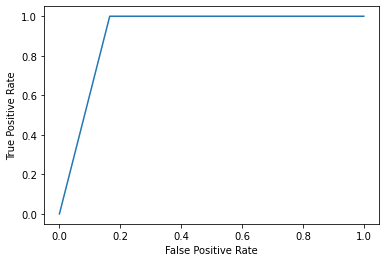

In [30]:
model = MyDecisionTreeClassifier(max_depth=2, min_samples_split=2)

czasek = time.perf_counter()
for i in range(10):
    tree_function(model, X_train, y_train, X_test, y_test, True)
print('Czas wykonania sklearn:', (time.perf_counter() - czasek))

tree_function(model, X_train, y_train, X_test, y_test)

Czas wykonania sklearn: 0.015835100000003877
Czulosc: 1.0
Swoistosc: 1.0
Accuracy: 1.0
ROC auc: 1.0
F1 score: 1.0
BA score: 1.0


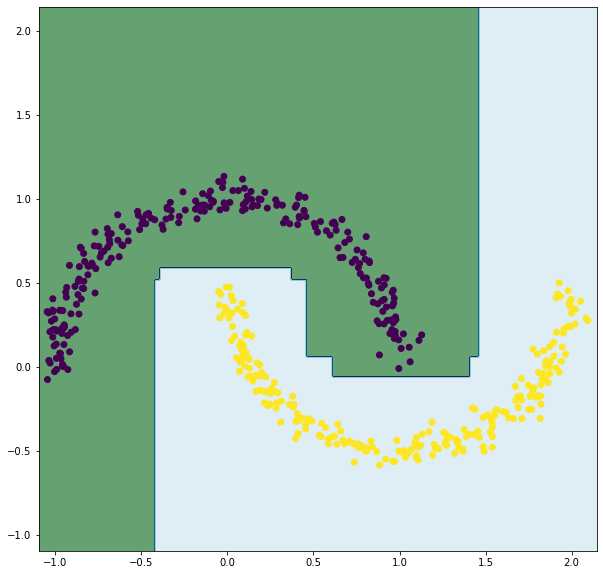

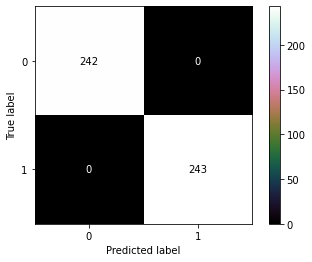

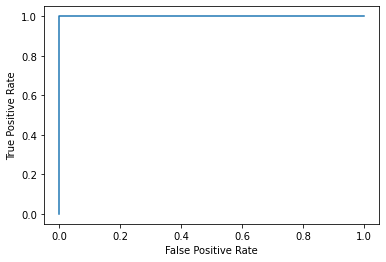

In [31]:
model = DecisionTreeClassifier(max_depth=samples, min_samples_split=2)

czasek = time.perf_counter()
for i in range(10):
    tree_function(model, X_train, y_train, X_test, y_test, True)
print('Czas wykonania sklearn:', (time.perf_counter() - czasek))

tree_function(model, X_train, y_train, X_test, y_test)

Czas wykonania sklearn: 19.432466000000204
Czulosc: 0.9838056680161943
Swoistosc: 1.0
Accuracy: 0.9917525773195877
ROC auc: 0.9917355371900827
F1 score: 0.9918367346938776
BA score: 0.9917355371900827


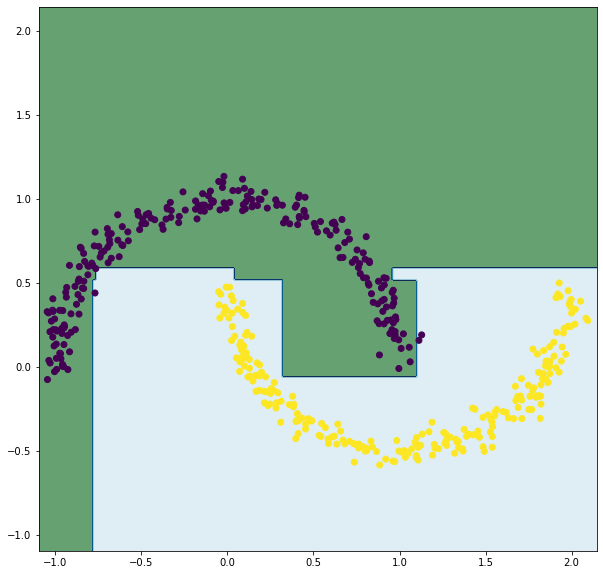

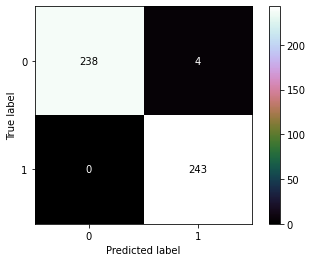

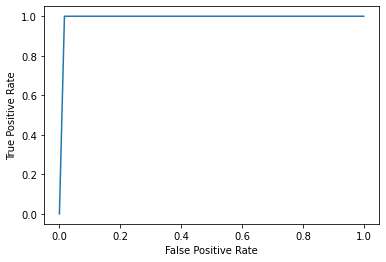

In [32]:
model = MyDecisionTreeClassifier(max_depth=samples, min_samples_split=2)

czasek = time.perf_counter()
for i in range(10):
    tree_function(model, X_train, y_train, X_test, y_test, True)
print('Czas wykonania sklearn:', (time.perf_counter() - czasek))

tree_function(model, X_train, y_train, X_test, y_test)

In [33]:
data = pd.read_csv('HTRU_2.csv', names=[x for x in range(0, 9)], header=None, index_col=False)
data
# 1. Mean of the integrated profile.
# 2. Standard deviation of the integrated profile.
# 3. Excess kurtosis of the integrated profile.
# 4. Skewness of the integrated profile.
# 5. Mean of the DM-SNR curve.
# 6. Standard deviation of the DM-SNR curve.
# 7. Excess kurtosis of the DM-SNR curve.
# 8. Skewness of the DM-SNR curve.
# 9. Class

,0,1,2,3,4,5,6,7,8
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0
...,...,...,...,...,...,...,...,...,...
17893,136.429688,59.847421,-0.187846,-0.738123,1.296823,12.166062,15.450260,285.931022,0
17894,122.554688,49.485605,0.127978,0.323061,16.409699,44.626893,2.945244,8.297092,0
17895,119.335938,59.935939,0.159363,-0.743025,21.430602,58.872000,2.499517,4.595173,0
17896,114.507812,53.902400,0.201161,-0.024789,1.946488,13.381731,10.007967,134.238910,0


In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17898 entries, 0 to 17897
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       17898 non-null  float64
 1   1       17898 non-null  float64
 2   2       17898 non-null  float64
 3   3       17898 non-null  float64
 4   4       17898 non-null  float64
 5   5       17898 non-null  float64
 6   6       17898 non-null  float64
 7   7       17898 non-null  float64
 8   8       17898 non-null  int64  
dtypes: float64(8), int64(1)
memory usage: 1.2 MB


In [35]:
data.isnull().sum()

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
dtype: int64

In [36]:
# data = data.dropna(axis=0, subset=[8])
#
# medians = data.median(axis=0, numeric_only=True)
# for index, value in medians.items():
#     data[index].fillna(value, inplace=True)
#
# data.head()

In [37]:
def winsorize(df):
    for i in df.columns:
        q1 = df[i].quantile(0.25)
        q3 = df[i].quantile(0.75)

        iqr = q3 - q1

        lower_bound = q1 - (1.5 * iqr)
        upper_bound = q3 + (1.5 * iqr)

        df.loc[df[i] < lower_bound, i] = lower_bound
        df.loc[df[i] > upper_bound, i] = upper_bound
    return df


def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        if df[feature_name].dtype == 'float64' or df[feature_name].dtype == 'int32':
            max_value = df[feature_name].max()
            min_value = df[feature_name].min()
            result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result



# data = winsorize(data)
data = normalize(data)
data

,0,1,2,3,4,5,6,7,8
0,0.721342,0.417687,0.165043,0.015627,0.013382,0.113681,0.294986,0.063890,0
1,0.517628,0.460908,0.235415,0.018268,0.006560,0.072524,0.364015,0.108443,0
2,0.520346,0.196868,0.221138,0.040677,0.013030,0.139188,0.288624,0.054610,0
3,0.700933,0.437884,0.181750,0.016534,0.015368,0.131583,0.266348,0.046581,0
4,0.443854,0.214847,0.249044,0.041712,0.004327,0.039684,0.462029,0.213369,0
...,...,...,...,...,...,...,...,...,...
17893,0.699218,0.473948,0.169741,0.015077,0.004855,0.046437,0.493364,0.241336,0
17894,0.624942,0.333936,0.201496,0.030260,0.072572,0.360761,0.161482,0.008612,0
17895,0.607712,0.475144,0.204652,0.015007,0.095069,0.498699,0.149653,0.005509,0
17896,0.581866,0.393617,0.208855,0.025283,0.007766,0.058209,0.348926,0.114181,0


In [38]:
data.corr().style.background_gradient(cmap='viridis')

,0,1,2,3,4,5,6,7,8
0,1.000000,0.547137,-0.873898,-0.738775,-0.298841,-0.307016,0.234331,0.144033,-0.673181
1,0.547137,1.000000,-0.521435,-0.539793,0.006869,-0.047632,0.029429,0.027691,-0.363708
2,-0.873898,-0.521435,1.000000,0.945729,0.414368,0.432880,-0.341209,-0.214491,0.791591
3,-0.738775,-0.539793,0.945729,1.000000,0.412056,0.415140,-0.328843,-0.204782,0.709528
4,-0.298841,0.006869,0.414368,0.412056,1.000000,0.796555,-0.615971,-0.354269,0.400876
5,-0.307016,-0.047632,0.432880,0.415140,0.796555,1.000000,-0.809786,-0.575800,0.491535
6,0.234331,0.029429,-0.341209,-0.328843,-0.615971,-0.809786,1.000000,0.923743,-0.390816
7,0.144033,0.027691,-0.214491,-0.204782,-0.354269,-0.575800,0.923743,1.000000,-0.259117
8,-0.673181,-0.363708,0.791591,0.709528,0.400876,0.491535,-0.390816,-0.259117,1.000000


In [39]:
from sklearn.model_selection import GridSearchCV

X = data.drop(axis=1, columns=8).to_numpy()
y = data[8].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=seed)

In [40]:
model_tree = DecisionTreeClassifier()
parameters = {'criterion': ('gini', 'entropy'),
              'max_depth': [x for x in range(1, 15)],
              'min_samples_split': [x for x in range(2, 5)],
              'min_samples_leaf': [x for x in range(1, 5)]}
clf = GridSearchCV(model_tree, parameters, n_jobs=4)

In [41]:
clf.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(), n_jobs=4,
             param_grid={'criterion': ('gini', 'entropy'),
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14],
                         'min_samples_leaf': [1, 2, 3, 4],
                         'min_samples_split': [2, 3, 4]})

In [42]:
print(clf.best_params_)

{'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 4}


In [43]:
y_predicted = clf.predict(X_test)

Czulosc: 0.8993288590604027
Swoistosc: 0.985679463741621
Accuracy: 0.9784916201117319
ROC auc: 0.9208026446923844
F1 score: 0.8743882544861339
BA score: 0.9208026446923843


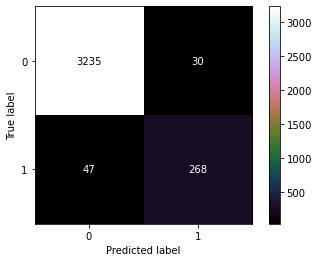

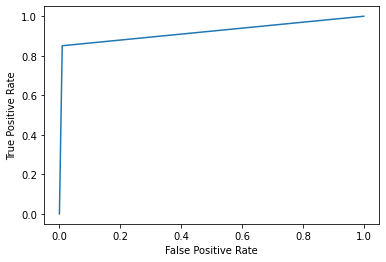

In [44]:
cm_model = confusion_matrix(y_test, y_predicted)
tn_model = cm_model[0][0]
fn_model = cm_model[0][1]
tp_model = cm_model[1][1]
fp_model = cm_model[1][0]
ConfusionMatrixDisplay(cm_model).plot(cmap='cubehelix')

fpr, tpr, roc_auc = roc_curve(y_test, y_predicted)

rok_model = RocCurveDisplay(fpr=fpr, tpr=tpr)
rok_model.plot()


print("Czulosc:", tp_model/(tp_model + fn_model))
print("Swoistosc:", tn_model/(tn_model + fp_model))
print("Accuracy:", (tp_model + tn_model) / (tp_model + tn_model + fp_model + fn_model))

print("ROC auc:", roc_auc_score(y_test, y_predicted))
print("F1 score:", f1_score(y_test, y_predicted))
print("BA score:", balanced_accuracy_score(y_test, y_predicted))

Czas dzialania:  0.08817950000047858
Czulosc: 0.8697068403908795
Swoistosc: 0.9853345554537122
Accuracy: 0.9754189944134078
ROC auc: 0.9176839495369359
F1 score: 0.8585209003215434
BA score: 0.9176839495369358


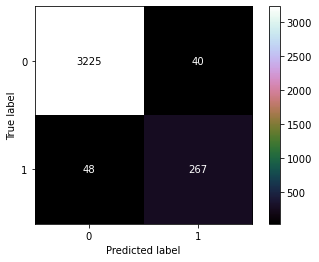

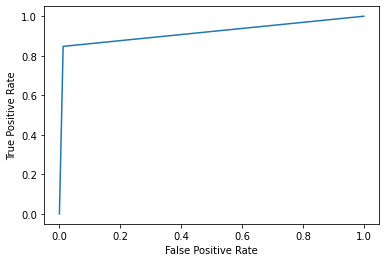

In [45]:
czasek = time.perf_counter()

model = DecisionTreeClassifier(max_depth= 10, min_samples_leaf= 1, min_samples_split= 2)

model.fit(X_train, y_train)

y_predicted = model.predict(X_test)

print('Czas dzialania: ', time.perf_counter() - czasek)

cm_model = confusion_matrix(y_test, y_predicted)
tn_model = cm_model[0][0]
fn_model = cm_model[0][1]
tp_model = cm_model[1][1]
fp_model = cm_model[1][0]
ConfusionMatrixDisplay(cm_model).plot(cmap='cubehelix')

fpr, tpr, roc_auc = roc_curve(y_test, y_predicted)

rok_model = RocCurveDisplay(fpr=fpr, tpr=tpr)
rok_model.plot()


print("Czulosc:", tp_model/(tp_model + fn_model))
print("Swoistosc:", tn_model/(tn_model + fp_model))
print("Accuracy:", (tp_model + tn_model) / (tp_model + tn_model + fp_model + fn_model))

print("ROC auc:", roc_auc_score(y_test, y_predicted))
print("F1 score:", f1_score(y_test, y_predicted))
print("BA score:", balanced_accuracy_score(y_test, y_predicted))

Czas dzialania:  0.09940460000052553
Czulosc: 0.7859237536656891
Swoistosc: 0.9854893485643718
Accuracy: 0.9664804469273743
ROC auc: 0.9142176523493523
F1 score: 0.8170731707317074
BA score: 0.9142176523493522


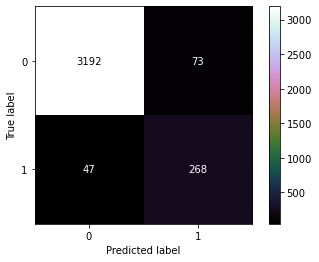

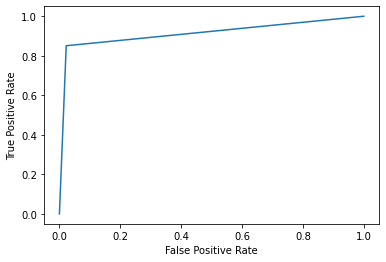

In [46]:
czasek = time.perf_counter()

model = DecisionTreeClassifier(max_depth= 100, min_samples_leaf= 1, min_samples_split= 2)

model.fit(X_train, y_train)

y_predicted = model.predict(X_test)

print('Czas dzialania: ', time.perf_counter() - czasek)

cm_model = confusion_matrix(y_test, y_predicted)
tn_model = cm_model[0][0]
fn_model = cm_model[0][1]
tp_model = cm_model[1][1]
fp_model = cm_model[1][0]
ConfusionMatrixDisplay(cm_model).plot(cmap='cubehelix')

fpr, tpr, roc_auc = roc_curve(y_test, y_predicted)

rok_model = RocCurveDisplay(fpr=fpr, tpr=tpr)
rok_model.plot()


print("Czulosc:", tp_model/(tp_model + fn_model))
print("Swoistosc:", tn_model/(tn_model + fp_model))
print("Accuracy:", (tp_model + tn_model) / (tp_model + tn_model + fp_model + fn_model))

print("ROC auc:", roc_auc_score(y_test, y_predicted))
print("F1 score:", f1_score(y_test, y_predicted))
print("BA score:", balanced_accuracy_score(y_test, y_predicted))

Czas dzialania:  0.0976942000006602
Czulosc: 0.7846607669616519
Swoistosc: 0.9848812095032398
Accuracy: 0.9659217877094972
ROC auc: 0.9110430491747491
F1 score: 0.8134556574923548
BA score: 0.911043049174749


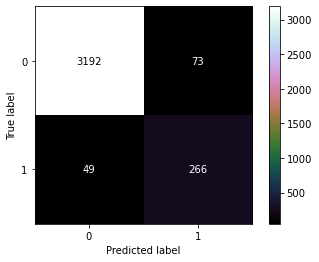

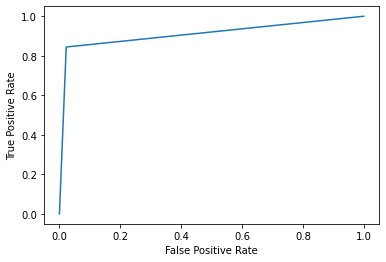

In [47]:
czasek = time.perf_counter()

model = DecisionTreeClassifier(max_depth= 1000, min_samples_leaf= 1, min_samples_split= 2)

model.fit(X_train, y_train)

y_predicted = model.predict(X_test)

print('Czas dzialania: ', time.perf_counter() - czasek)

cm_model = confusion_matrix(y_test, y_predicted)
tn_model = cm_model[0][0]
fn_model = cm_model[0][1]
tp_model = cm_model[1][1]
fp_model = cm_model[1][0]
ConfusionMatrixDisplay(cm_model).plot(cmap='cubehelix')

fpr, tpr, roc_auc = roc_curve(y_test, y_predicted)

rok_model = RocCurveDisplay(fpr=fpr, tpr=tpr)
rok_model.plot()


print("Czulosc:", tp_model/(tp_model + fn_model))
print("Swoistosc:", tn_model/(tn_model + fp_model))
print("Accuracy:", (tp_model + tn_model) / (tp_model + tn_model + fp_model + fn_model))

print("ROC auc:", roc_auc_score(y_test, y_predicted))
print("F1 score:", f1_score(y_test, y_predicted))
print("BA score:", balanced_accuracy_score(y_test, y_predicted))

Czas dzialania:  303.04141940000045
Czulosc: 0.8525641025641025
Swoistosc: 0.9850061199510404
Accuracy: 0.973463687150838
ROC auc: 0.915177811808746
F1 score: 0.8484848484848485
BA score: 0.9151778118087459


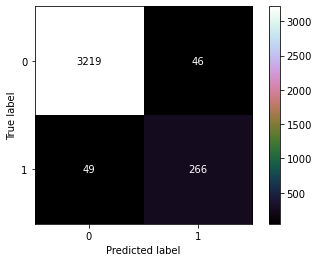

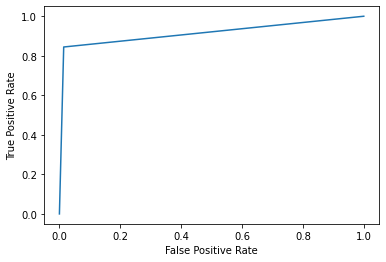

In [48]:
czasek = time.perf_counter()

model = MyDecisionTreeClassifier(max_depth= 10, min_samples_split= 2)

model.fit(X_train, y_train)

y_predicted = model.predict(X_test)

print('Czas dzialania: ', time.perf_counter() - czasek)

cm_model = confusion_matrix(y_test, y_predicted)
tn_model = cm_model[0][0]
fn_model = cm_model[0][1]
tp_model = cm_model[1][1]
fp_model = cm_model[1][0]
ConfusionMatrixDisplay(cm_model).plot(cmap='cubehelix')

fpr, tpr, roc_auc = roc_curve(y_test, y_predicted)

rok_model = RocCurveDisplay(fpr=fpr, tpr=tpr)
rok_model.plot()


print("Czulosc:", tp_model/(tp_model + fn_model))
print("Swoistosc:", tn_model/(tn_model + fp_model))
print("Accuracy:", (tp_model + tn_model) / (tp_model + tn_model + fp_model + fn_model))

print("ROC auc:", roc_auc_score(y_test, y_predicted))
print("F1 score:", f1_score(y_test, y_predicted))
print("BA score:", balanced_accuracy_score(y_test, y_predicted))

Czas dzialania:  299.66908839999996
Czulosc: 0.8229813664596274
Swoistosc: 0.9846531614487416
Accuracy: 0.9701117318435755
ROC auc: 0.9119059772964827
F1 score: 0.8320251177394035
BA score: 0.9119059772964826


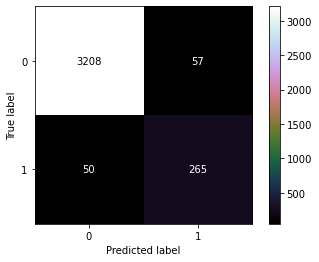

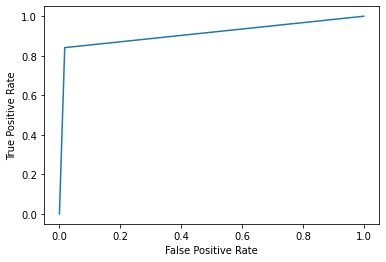

In [49]:
czasek = time.perf_counter()

model = MyDecisionTreeClassifier(max_depth= 100, min_samples_split= 2)

model.fit(X_train, y_train)

y_predicted = model.predict(X_test)

print('Czas dzialania: ', time.perf_counter() - czasek)

cm_model = confusion_matrix(y_test, y_predicted)
tn_model = cm_model[0][0]
fn_model = cm_model[0][1]
tp_model = cm_model[1][1]
fp_model = cm_model[1][0]
ConfusionMatrixDisplay(cm_model).plot(cmap='cubehelix')

fpr, tpr, roc_auc = roc_curve(y_test, y_predicted)

rok_model = RocCurveDisplay(fpr=fpr, tpr=tpr)
rok_model.plot()


print("Czulosc:", tp_model/(tp_model + fn_model))
print("Swoistosc:", tn_model/(tn_model + fp_model))
print("Accuracy:", (tp_model + tn_model) / (tp_model + tn_model + fp_model + fn_model))

print("ROC auc:", roc_auc_score(y_test, y_predicted))
print("F1 score:", f1_score(y_test, y_predicted))
print("BA score:", balanced_accuracy_score(y_test, y_predicted))

Czas dzialania:  299.39323049999985
Czulosc: 0.8229813664596274
Swoistosc: 0.9846531614487416
Accuracy: 0.9701117318435755
ROC auc: 0.9119059772964827
F1 score: 0.8320251177394035
BA score: 0.9119059772964826


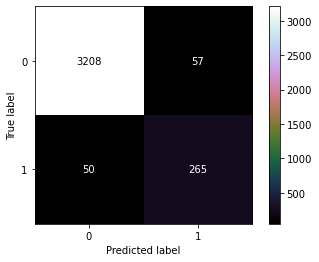

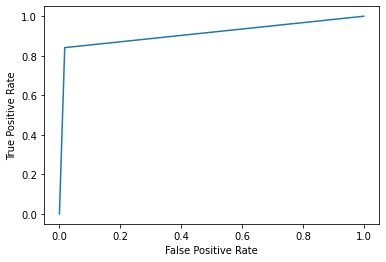

In [50]:
czasek = time.perf_counter()

model = MyDecisionTreeClassifier(max_depth= 1000, min_samples_split= 2)

model.fit(X_train, y_train)

y_predicted = model.predict(X_test)

print('Czas dzialania: ', time.perf_counter() - czasek)

cm_model = confusion_matrix(y_test, y_predicted)
tn_model = cm_model[0][0]
fn_model = cm_model[0][1]
tp_model = cm_model[1][1]
fp_model = cm_model[1][0]
ConfusionMatrixDisplay(cm_model).plot(cmap='cubehelix')

fpr, tpr, roc_auc = roc_curve(y_test, y_predicted)

rok_model = RocCurveDisplay(fpr=fpr, tpr=tpr)
rok_model.plot()


print("Czulosc:", tp_model/(tp_model + fn_model))
print("Swoistosc:", tn_model/(tn_model + fp_model))
print("Accuracy:", (tp_model + tn_model) / (tp_model + tn_model + fp_model + fn_model))

print("ROC auc:", roc_auc_score(y_test, y_predicted))
print("F1 score:", f1_score(y_test, y_predicted))
print("BA score:", balanced_accuracy_score(y_test, y_predicted))

# Wnioski

Model SKLEARN poradzil sobie lepiej niz stworzony klasyfikator. Stworzona implementacja miala problemy z policzeniem danych, dlatego zbior uczacy zostal zredukowany do 500 probek.

"Czy wybieraj¡c cel dla pierwszej sondy mającej za zadanie zbadać pulsar z bliska uzasadnione jest poszukiwanie optymalnej głębokości drzewa?"

Tak poniewaz optymalna wysokosc drzewa wplywa na jego klasyfikacje - przy optymalnych parametrach wyniki klasyfikacji byly lepsze. Wyslanie sondy w niewlasciwe miejsce (np. do miejsca sklasyfikowanego jako pulsar ktore by nim nie bylo) mogloby spowodowac znaczace straty finansowe.

In [51]:
 ! jupyter nbconvert --to html lab5.ipynb

[NbConvertApp] Converting notebook lab5.ipynb to html
[NbConvertApp] Writing 2598550 bytes to lab5.html
